In [77]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4

In [78]:
import yfinance as yf
from stockstats import StockDataFrame as Sdf

import pandas as pd
import matplotlib.pyplot as plt

import gym
from stable_baselines import PPO2, DDPG, A2C, ACKTR, TD3
from stable_baselines import DDPG
from stable_baselines import A2C
from stable_baselines import SAC
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpPolicy

In [ ]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [79]:
# Download and save the data in a pandas DataFrame:
data_df = yf.download("RELIANCE.NS", start="2006-01-01", end="2021-06-23")

[*********************100%***********************]  1 of 1 completed


In [80]:
data_df.shape

(3806, 6)

In [81]:
# reset the index, we want to use numbers instead of dates
data_df=data_df.reset_index()

In [82]:
data_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-01-02,138.170441,139.562988,137.729477,138.920868,122.589737,23666465
1,2006-01-03,139.176163,142.951492,138.634628,142.348053,125.614052,31699387
2,2006-01-04,142.502777,144.823669,142.348053,143.872101,126.958916,27926553
3,2006-01-05,144.359497,144.823669,142.348053,142.611084,125.846146,34309779
4,2006-01-06,142.611084,144.119675,141.280441,142.456360,125.709595,41098419


In [83]:
data_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [84]:
# convert the column names to standardized names
data_df.columns = ['datadate','open','high','low','close','adjcp','volume']

In [85]:
# check missing data 
data_df.isnull().values.any()

False

In [86]:
# calculate technical indicators like MACD
stock = Sdf.retype(data_df.copy())
# we need to use adjusted close price instead of close price
stock['close'] = stock['adjcp']
data_df['macd'] = stock['macd']

In [87]:
# check missing data again
data_df.isnull().values.any()

False

In [88]:
data_df.head()

,datadate,open,high,low,close,adjcp,volume,macd
0,2006-01-02,138.170441,139.562988,137.729477,138.920868,122.589737,23666465,0.000000
1,2006-01-03,139.176163,142.951492,138.634628,142.348053,125.614052,31699387,0.067853
2,2006-01-04,142.502777,144.823669,142.348053,143.872101,126.958916,27926553,0.128163
3,2006-01-05,144.359497,144.823669,142.348053,142.611084,125.846146,34309779,0.112275
4,2006-01-06,142.611084,144.119675,141.280441,142.456360,125.709595,41098419,0.095845


In [90]:
data_clean = data_df.copy()

In [91]:
data_clean.head()

,datadate,open,high,low,close,adjcp,volume,macd
0,2006-01-02,138.170441,139.562988,137.729477,138.920868,122.589737,23666465,0.000000
1,2006-01-03,139.176163,142.951492,138.634628,142.348053,125.614052,31699387,0.067853
2,2006-01-04,142.502777,144.823669,142.348053,143.872101,126.958916,27926553,0.128163
3,2006-01-05,144.359497,144.823669,142.348053,142.611084,125.846146,34309779,0.112275
4,2006-01-06,142.611084,144.119675,141.280441,142.456360,125.709595,41098419,0.095845


In [92]:
data_clean.tail()

,datadate,open,high,low,close,adjcp,volume,macd
3801,2021-06-16,2244.899902,2247.050049,2205.850098,2211.600098,2211.600098,4982975,65.578767
3802,2021-06-17,2200.000000,2235.000000,2179.899902,2215.649902,2215.649902,7266765,63.210799
3803,2021-06-18,2225.500000,2235.000000,2184.350098,2225.649902,2225.649902,13553801,61.432923
3804,2021-06-21,2203.500000,2247.500000,2200.149902,2237.250000,2237.250000,5624044,60.265274
3805,2021-06-22,2254.000000,2261.000000,2219.350098,2225.750000,2225.750000,5940386,57.746286


In [102]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Global variables
HMAX_NORMALIZE = 200
INITIAL_ACCOUNT_BALANCE=100000
STOCK_DIM = 1

# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001
# REWARD_SCALING = 1e-3


class SingleStockEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0):
        #super(StockEnv, self).__init__()
        # date increment
        self.day = day
        self.df = df
        # action_space normalization and the shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 4: [Current Balance]+[prices]+[owned shares] +[macd] 
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (4,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        # termination
        self.terminal = False  
        # save the total number of trades
        self.trades = 0
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd] 
        # initialize reward and cost
        self.reward = 0
        self.cost = 0
        
        # memorize the total value, total rewards
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []

    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+STOCK_DIM+1] > 0:
            # update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)
            # update held shares
            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            # update transaction costs
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass
            
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)
        # update held shares
        self.state[index+STOCK_DIM+1] += min(available_amount, action)
        # update transaction costs
        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('/content/drive/MyDrive/AIML/account_value_PPORS1.png')
            plt.close()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0])) 
            print("end_total_asset:{}".format(end_total_asset))
            
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('/content/drive/MyDrive/AIML/account_value_PPORS1.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))- INITIAL_ACCOUNT_BALANCE ))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)
            
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            
            if df_total_value['daily_return'].std()!=0:
                sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                      df_total_value['daily_return'].std()
                print("Sharpe: ",sharpe)
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('/content/drive/MyDrive/AIML/account_rewards_PPORS1.csv')
            return self.state, self.reward, self.terminal,{}

        else:
            
            # actions are the shares we need to buy, hold, or sell
            actions = actions * HMAX_NORMALIZE
            # calculate begining total asset
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            # perform buy or sell action
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])
            
            # update data, walk a step s'
            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            self.state =  [self.state[0]] + \
                          [self.data.adjcp] + \
                          list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) +\
                          [self.data.macd]
                        
            # calculate the end total asset
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.reward = end_total_asset - begin_total_asset  
            self.rewards_memory.append(self.reward)
            #self.reward = self.reward * REWARD_SCALING
            self.asset_memory.append(end_total_asset)

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd]
        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [103]:
train = data_clean[(data_clean.datadate>='2006-01-01') & (data_clean.datadate<'2019-01-01')]
# the index needs to start from 0
train=train.reset_index(drop=True)

In [104]:
train.head()

,datadate,open,high,low,close,adjcp,volume,macd
0,2006-01-02,138.170441,139.562988,137.729477,138.920868,122.589737,23666465,0.000000
1,2006-01-03,139.176163,142.951492,138.634628,142.348053,125.614052,31699387,0.067853
2,2006-01-04,142.502777,144.823669,142.348053,143.872101,126.958916,27926553,0.128163
3,2006-01-05,144.359497,144.823669,142.348053,142.611084,125.846146,34309779,0.112275
4,2006-01-06,142.611084,144.119675,141.280441,142.456360,125.709595,41098419,0.095845


In [105]:
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ppo = PPO2('MlpPolicy', env_train, tensorboard_log="/content/drive/MyDrive/AIML/single_stock_trading_2_tensorboard/")
model_ppo.learn(total_timesteps=100000,tb_log_name="run_aapl_ppo")
model_ppo.save('/content/drive/MyDrive/AIML/AIML-PPO-RS')

previous_total_asset:100000
end_total_asset:128097.94341657136
total_reward:28097.94341657136
total_cost:  93749.59965379046
total trades:  2867
Sharpe:  0.19797953578612115
previous_total_asset:100000
end_total_asset:77871.46725547464
total_reward:-22128.532744525364
total_cost:  79200.65051747489
total trades:  3022
Sharpe:  0.038310737727044776
previous_total_asset:100000
end_total_asset:27112.501998216037
total_reward:-72887.49800178397
total_cost:  44059.97250535478
total trades:  2884
Sharpe:  -0.29091610689977404
previous_total_asset:100000
end_total_asset:129719.19199029477
total_reward:29719.19199029477
total_cost:  94252.5973868625
total trades:  3079
Sharpe:  0.20910820295850094
previous_total_asset:100000
end_total_asset:197045.06613936872
total_reward:97045.06613936872
total_cost:  114115.15384659042
total trades:  3138
Sharpe:  0.33324268774006993
previous_total_asset:100000
end_total_asset:201524.15202927223
total_reward:101524.15202927223
total_cost:  119403.88311268804

In [ ]:
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ddpg = DDPG('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_ddpg.learn(total_timesteps=100000, tb_log_name="run_aapl_ddpg")
model_ddpg.save('/content/drive/MyDrive/AIML/AIML-DDPG-RS')

Instructions for updating:
Use keras.layers.Dense instead.





previous_total_asset:100000
end_total_asset:407604.8917759615
total_reward:307604.8917759615
total_cost:  104.95980143040423
total trades:  3048
Sharpe:  0.5054043885386251
previous_total_asset:100000
end_total_asset:874236.0895262494
total_reward:774236.0895262494
total_cost:  99.811105470196
total trades:  3197
Sharpe:  0.6735066249497496
previous_total_asset:100000
end_total_asset:874318.5002434897
total_reward:774318.5002434897
total_cost:  99.82153017620465
total trades:  3197
Sharpe:  0.6735161516077431
previous_total_asset:100000
end_total_asset:874333.3892178121
total_reward:774333.3892178121
total_cost:  99.82341082648725
total trades:  3197
Sharpe:  0.6735178759354146
previous_total_asset:100000
end_total_asset:874337.7139488917
total_reward:774337.7139488917
total_cost:  99.82395631641396
total trades:  3197
Sharpe:  0.6735183777029943
previous_total_asset:100000
end_total_asset:874339.022166802
total_reward:774

In [101]:
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_a2c = A2C('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_a2c.learn(total_timesteps=100000,tb_log_name="run_aapl_a2c")
model_a2c.save('/content/drive/MyDrive/AIML/AIML-A2C-RS1')

previous_total_asset:100000
end_total_asset:69217.30792304539
total_reward:-30782.692076954612
total_cost:  55001.19749672063
total trades:  2698
Sharpe:  -0.01586416233096976
previous_total_asset:100000
end_total_asset:83086.49743672392
total_reward:-16913.50256327608
total_cost:  37278.92249847613
total trades:  2909
Sharpe:  0.06848632334591245
previous_total_asset:100000
end_total_asset:487767.0155279937
total_reward:387767.0155279937
total_cost:  74288.4114019975
total trades:  3197
Sharpe:  0.5540992880263188
previous_total_asset:100000
end_total_asset:379166.1453488808
total_reward:279166.1453488808
total_cost:  57763.523877827494
total trades:  3075
Sharpe:  0.5089938683803088
previous_total_asset:100000
end_total_asset:690289.0525699427
total_reward:590289.0525699427
total_cost:  37917.853088051794
total trades:  3179
Sharpe:  0.6435628381720351
previous_total_asset:100000
end_total_asset:728568.355072628
total_reward:628568.355072628
total_cost:  15001.207671716647
total trad

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
#DQN<DDPG<TD3
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_td3_new = TD3('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_td3_new.learn(total_timesteps=100000,tb_log_name="run_aapl_td3")
model_td3_new.save('/content/drive/MyDrive/AIML/AIML-TD3RS')

previous_total_asset:100000
end_total_asset:633209.4933370915
total_reward:533209.4933370915
total_cost:  1400.4529337650472
total trades:  3186
Sharpe:  0.6059203726694704
previous_total_asset:100000
end_total_asset:874339.8988976898
total_reward:774339.8988976898
total_cost:  99.8242315826416
total trades:  3197
Sharpe:  0.6735186315931301
previous_total_asset:100000
end_total_asset:874339.8988976898
total_reward:774339.8988976898
total_cost:  99.8242315826416
total trades:  3197
Sharpe:  0.6735186315931301
previous_total_asset:100000
end_total_asset:874339.8988976898
total_reward:774339.8988976898
total_cost:  99.8242315826416
total trades:  3197
Sharpe:  0.6735186315931301
previous_total_asset:100000
end_total_asset:874339.8988976898
total_reward:774339.8988976898
total_cost:  99.8242315826416
total trades:  3197
Sharpe:  0.6735186315931301
previous_total_asset:100000
end_total_asset:874339.8988976898
total_reward:774339.8988976898
total_cost:  99.8242315826416
total trades:  3197


In [106]:
test = data_clean[(data_clean.datadate>='2019-01-01') ]
# the index needs to start from 0
test=test.reset_index(drop=True)

In [107]:
test.head()

,datadate,open,high,low,close,adjcp,volume,macd
0,2019-01-01,1114.683960,1116.714722,1099.676147,1110.473877,1096.698975,4498087,-1.336785
1,2019-01-02,1104.034912,1116.417480,1090.661621,1096.010864,1082.415405,7212697,-2.134170
2,2019-01-03,1097.100586,1104.133911,1079.864014,1082.489136,1069.061401,7517041,-3.799857
3,2019-01-04,1087.095459,1094.079224,1070.948486,1088.333740,1074.833496,8545382,-4.601127
4,2019-01-07,1096.605225,1107.947754,1090.661621,1094.376465,1080.801270,5565822,-4.700407


In [111]:
model = model_ppo
env_test = DummyVecEnv([lambda: SingleStockEnv(test)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:146693.72898495573
total_reward:46693.72898495573
total_cost:  21015.99735302662
total trades:  522
Sharpe:  0.7403368611315312


In [ ]:
model = model_ddpg
env_test = DummyVecEnv([lambda: SingleStockEnv(test)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:202643.84370385745
total_reward:102643.84370385745
total_cost:  99.79960668945313
total trades:  607
Sharpe:  0.9827749296469772


In [ ]:
model = model_a2c
env_test = DummyVecEnv([lambda: SingleStockEnv(test)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:202643.84370385745
total_reward:102643.84370385745
total_cost:  99.79960668945313
total trades:  607
Sharpe:  0.9827749296469772


In [ ]:
model = model_td3_new
env_test = DummyVecEnv([lambda: SingleStockEnv(test)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:202643.84370385745
total_reward:102643.84370385745
total_cost:  99.79960668945313
total trades:  607
Sharpe:  0.9827749296469772


In [ ]:
def get_DRL_sharpe():
    df_total_value=pd.read_csv('/content/drive/MyDrive/AIML/account_value_TD3RS1.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    print(df_total_value)
    sharpe = (252**0.5)*df_total_value['daily_return'].mean()/df_total_value['daily_return'].std()
    
    annual_return = ((df_total_value['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    return df_total_value

In [ ]:
def get_buy_and_hold_sharpe(test):
    test['daily_return']=test['adjcp'].pct_change(1)
    sharpe = (252**0.5)*test['daily_return'].mean()/ \
    test['daily_return'].std()
    annual_return = ((test['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)

    print("sharpe ratio: ", sharpe)
    return sharpe

In [ ]:
df_total_value=get_DRL_sharpe()

     account_value  daily_return
0    100000.000000           NaN
1     98600.395584     -0.013996
2     97385.181228     -0.012325
3     97707.046372      0.003305
4     98214.580214      0.005194
..             ...           ...
603  156271.474383     -0.017037
604  156557.125441      0.001828
605  156586.657716      0.000189
606  157278.701278      0.004420
607  156471.274927     -0.005134

[608 rows x 2 columns]
annual return:  27.012655293238687
sharpe ratio:  0.7298113955608929


In [ ]:
get_buy_and_hold_sharpe(test)

annual return:  43.3962623974796
sharpe ratio:  0.9839858552025519


0.9839858552025519

In [ ]:
DRL_cumulative_return = (df_total_value.account_value.pct_change(1)+1).cumprod()-1
buy_and_hold_cumulative_return = (test.adjcp.pct_change(1)+1).cumprod()-1

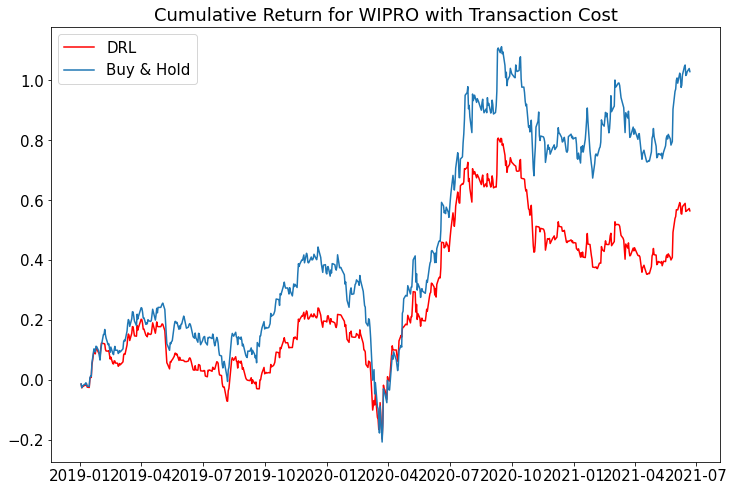

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(test.datadate, DRL_cumulative_return, color='red',label = "DRL")
plt.plot(test.datadate, buy_and_hold_cumulative_return, label = "Buy & Hold")
plt.title("Cumulative Return for WIPRO with Transaction Cost",size= 18)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)